In [39]:
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn .impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
# import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.compose import ColumnTransformer

In [47]:
def convert_datetime(datetime_str):
    # Parse the datetime string into a datetime object
    dt_obj = datetime.fromisoformat(datetime_str.split('+')[0])
    
    # Extract year, month name, and day
    year = dt_obj.year
    Month = dt_obj.strftime("%B")  # Get month name
    month=int(dt_obj.strftime("%m"))
    day = int(dt_obj.strftime("%d"))
    hour = dt_obj.hour # Capture the hour

    return year, month, day, hour

class LoadPredictor():
    def __init__(self, df, model_type ='gradient_boost'):
        self.df = df.copy()
        
        self.model_type = model_type
        self.preprocess()

    
    def preprocess(self):
        self.df = self.df.rename(columns={"total load actual":"total_actual_load"})
        self.df = self.df.dropna(subset=["total_actual_load"])
        self.y = self.df["total_actual_load"]
        self.df[['year','month','day', 'hour']]=self.df['dt_iso'].apply(lambda x: pd.Series(convert_datetime(x)))
        self.add_prev_day_avg_load()
        self.drop_generation()
        # self.add_lagged_features()

    
    # def add_lagged_features(self, target_col='total_actual_load', lags=[1, 3, 7]):
    #     for lag in lags:
    #         self.df[f'{target_col}_lag{lag}'] = self.df[target_col].shift(lag)
    #     return
    def add_prev_day_avg_load(self):
        def get_prev_day(datetime_str, n_day=1):
            dt_obj = datetime.fromisoformat(datetime_str.split('+')[0])
            yesterday = dt_obj - timedelta(days=n_day)
            year = yesterday.year
    
            month=int(yesterday.strftime("%m"))
            day = int(yesterday.strftime("%d"))

            return year, month, day
        



            
        daily_averages = self.df.groupby(['year', 'month', 'day'])['total_actual_load'].mean()
        
        self.df['previous_day_average'] = self.df.apply(lambda row: daily_averages.get((get_prev_day(row['dt_iso'])), 0), axis=1)
        self.df['previous_day_average_2'] = self.df.apply(lambda row: daily_averages.get((get_prev_day(row['dt_iso'], 2)), 0), axis=1)
        self.df['previous_day_average_3'] = self.df.apply(lambda row: daily_averages.get((get_prev_day(row['dt_iso'], 3)), 0), axis=1)
        self.df['previous_day_average_4'] = self.df.apply(lambda row: daily_averages.get((get_prev_day(row['dt_iso'], 4)), 0), axis=1)

        return 

    
    def drop_generation(self):
        self.df= self.df.drop(columns=['generation marine','generation nuclear','generation other renewable','generation solar','generation hydro pumped storage aggregated','generation hydro pumped storage consumption','generation hydro run-of-river and poundage','generation other','generation fossil oil','generation fossil oil shale','generation fossil peat','generation geothermal','generation hydro water reservoir','generation biomass','generation fossil brown coal/lignite','generation fossil coal-derived gas','generation fossil gas','generation fossil hard coal','generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable','forecast solar day ahead','forecast wind offshore eday ahead','forecast wind onshore day ahead','price day ahead','price actual','generation wind offshore','generation wind onshore','generation waste','snow_3h_Barcelona','snow_3h_Seville',
       'generation solar','total load forecast','total_actual_load','snow_3h_Valencia','day','weather_id_Seville','pressure_Barcelona','clouds_all_Bilbao','rain_3h_Seville', 'snow_3h_Madrid','pressure_Valencia','rain_3h_Madrid','pressure_Madrid'])
      
        return
    
    def get_correlation(self):
        corr_df=self.df.copy()
        column_names_object = corr_df.select_dtypes(include=['object']).columns.tolist()
        corr_df=corr_df.drop(column_names_object,axis=1)
        corr_df["total_actual_load"]=self.y
        correlations = corr_df.corr(method='pearson')
        
        print(correlations["total_actual_load"].sort_values(ascending=False).to_string())
        return correlations
    def create_pipeline(self):
        column_names_object = self.df.select_dtypes(include=['object']).columns.tolist()
        column_names_num=self.df.select_dtypes(include=['float64','int64']).columns.tolist()
        cat_feature=self.df[column_names_object]


        # Create the Pipeline for encoding categorical features
        cat_pipe = Pipeline([
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])
        # Fit and transform your data
        encoded_cat_features = cat_pipe.fit_transform(cat_feature)

        num_features=self.df[column_names_num]

        # Build a Numeric Pipeline that utilizies Univariate Imputation to handle any missing values
        # and Standardizes each column with respect to its average so that the data is scale-invariant
        num_pipe = Pipeline(
            steps=[
                ("interpolation", KNNImputer(n_neighbors=5)),
                ("standardization", MinMaxScaler())
            ]
        )

        # Examine the transformed (properly encoded numeric features)
        encoded_num_features = num_pipe.fit_transform(num_features)

        preprocessor_pipe = ColumnTransformer(
        transformers=[
            ('numeric', num_pipe,num_features.columns.tolist()),
            ('categorical', cat_pipe,cat_feature.columns.tolist())
        ])
        return preprocessor_pipe
    
    def get_df(self):
        return self.df
    def train_test(self):
        X,y=self.df,self.y

        #Randomly dividing it into training and testing sets

        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42,shuffle=True)
        preprocessor_pipe = self.create_pipeline()

        model=Pipeline(
            steps=[ ("preprocessing-pipe", preprocessor_pipe),    
                    # ("pca", TruncatedSVD(n_components=30)),
                #    ("polynomial-features", polynomial_converter),
                ("xgboost", GradientBoostingRegressor(n_estimators=300,
                learning_rate=0.5,
                criterion="squared_error",
                max_depth=8,))]
        )

        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
        r2=r2_score(y_test,y_pred)
        print(f"The root square score is:{r2}")
        rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
        print(rmse)

we_df=pd.read_csv("/Users/sabnampandit/Desktop/BDA602/FinalProject/Project/Energy_Weather_Dataset.csv")
load_predictor = LoadPredictor(df= we_df)
pipe = load_predictor.create_pipeline()
print(pipe)
load_predictor.train_test()


# load_predictor.train_test()


/var/folders/5t/vtdcn2bn3zg2_494bdsr93600000gn/T/ipykernel_84527/171059224.py:26: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  self.df[['year','month','day', 'hour']]=self.df['dt_iso'].apply(lambda x: pd.Series(convert_datetime(x)))


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('interpolation',
                                                  KNNImputer()),
                                                 ('standardization',
                                                  MinMaxScaler())]),
                                 ['Unnamed: 0', 'temp_Valencia',
                                  'temp_min_Valencia', 'temp_max_Valencia',
                                  'humidity_Valencia', 'wind_speed_Valencia',
                                  'wind_deg_Valencia', 'rain_1h_Valencia',
                                  'rain_3h_Valencia', 'clouds_all_Valencia',
                                  'weather_id_Valencia', 'temp_Madr...
                                  'weather_description_Valencia',
                                  'weather_icon_Valencia',
                                  'weather_main_Madrid',
                                  'weather_description_Madrid'

/opt/anaconda3/envs/bda_696_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


total_actual_load       1.000000
hour                    0.539143
temp_min_Valencia       0.222588
temp_Valencia           0.207391
temp_Seville            0.190850
temp_min_Seville        0.190688
temp_max_Madrid         0.188348
temp_max_Valencia       0.186146
temp_Bilbao             0.183744
temp_max_Bilbao         0.182818
temp_min_Bilbao         0.180196
temp_min_Barcelona      0.172269
temp_Madrid             0.167922
temp_max_Seville        0.166504
wind_speed_Bilbao       0.160538
temp_Barcelona          0.151442
wind_speed_Seville      0.144165
wind_speed_Valencia     0.142636
temp_min_Madrid         0.133945
temp_max_Barcelona      0.130947
wind_speed_Barcelona    0.113305
wind_speed_Madrid       0.090010
rain_1h_Madrid          0.079466
year                    0.065833
clouds_all_Valencia     0.057934
Unnamed: 0              0.052420
wind_deg_Bilbao         0.050498
clouds_all_Madrid       0.048315
rain_1h_Valencia        0.033615
rain_1h_Seville         0.026430
rain_1h_Bi

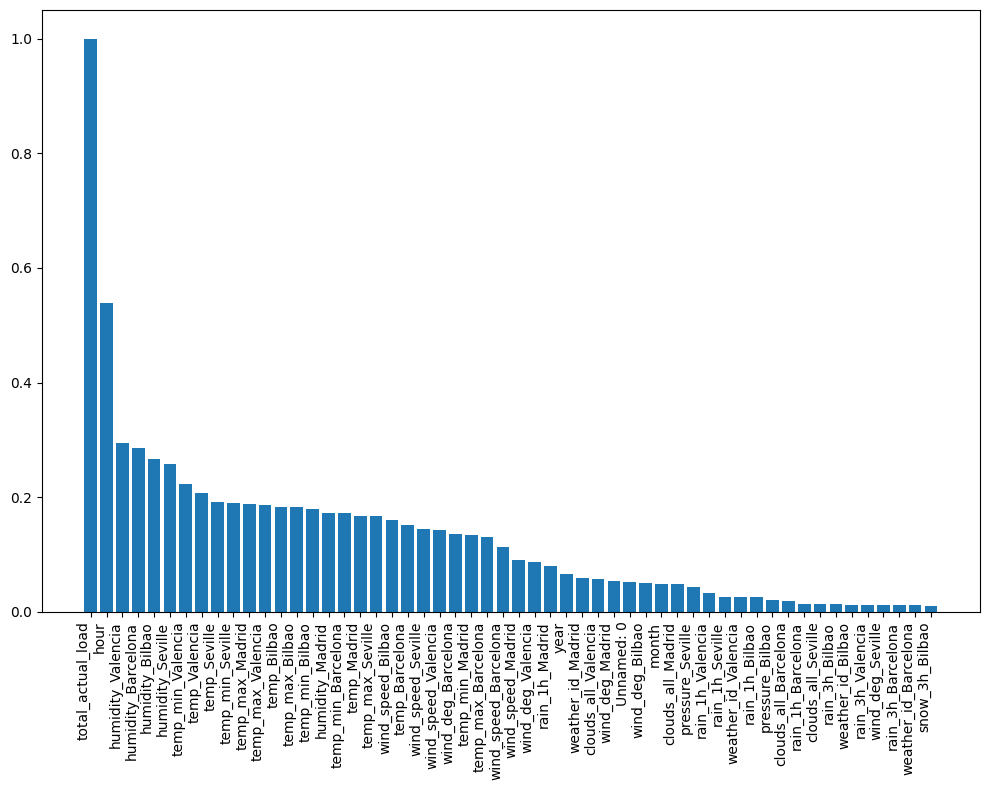

,Unnamed: 0,temp_Valencia,temp_min_Valencia,temp_max_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,clouds_all_Valencia,...,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,weather_id_Bilbao,year,month,hour,total_actual_load
Unnamed: 0,1.000000,0.092000,0.151127,0.033704,0.026422,0.003216,0.043810,-0.082502,-0.060494,-0.034315,...,0.092683,-0.061169,-0.191765,-0.073443,-0.074896,0.109865,0.967926,0.225042,-0.002588,0.052420
temp_Valencia,0.092000,1.000000,0.987237,0.988353,-0.413804,0.079796,-0.237671,-0.077821,-0.022009,-0.040180,...,0.068576,0.083886,-0.109172,0.005476,-0.072739,0.103180,0.042515,0.208341,0.269414,0.207391
temp_min_Valencia,0.151127,0.987237,1.000000,0.954082,-0.411941,0.084182,-0.234828,-0.079294,-0.021371,-0.032353,...,0.072082,0.085411,-0.103350,0.003245,-0.070732,0.097133,0.103061,0.206736,0.279132,0.222588
temp_max_Valencia,0.033704,0.988353,0.954082,1.000000,-0.403283,0.072513,-0.236692,-0.074264,-0.020448,-0.045111,...,0.062846,0.082249,-0.111993,0.007964,-0.073336,0.106007,-0.016459,0.207004,0.253389,0.186146
humidity_Valencia,0.026422,-0.413804,-0.411941,-0.403283,1.000000,-0.388767,-0.096721,0.138538,0.023314,0.257668,...,-0.246953,-0.197675,-0.083848,-0.003723,-0.038992,0.063527,-0.017611,0.172332,-0.336181,-0.295320
wind_speed_Valencia,0.003216,0.079796,0.084182,0.072513,-0.388767,1.000000,0.262442,0.022726,-0.021097,0.061512,...,0.324842,0.193574,0.189927,-0.026756,0.081647,-0.128143,0.052355,-0.198231,0.193984,0.142636
wind_deg_Valencia,0.043810,-0.237671,-0.234828,-0.236692,-0.096721,0.262442,1.000000,-0.008385,0.001861,-0.062222,...,0.052426,0.074952,0.129944,0.009998,0.042574,-0.129418,0.066238,-0.088489,-0.137305,-0.087768
rain_1h_Valencia,-0.082502,-0.077821,-0.079294,-0.074264,0.138538,0.022726,-0.008385,1.000000,-0.008458,0.252653,...,-0.017785,0.024434,0.115614,-0.003028,0.016370,-0.068766,-0.078556,-0.029486,0.023438,0.033615
rain_3h_Valencia,-0.060494,-0.022009,-0.021371,-0.020448,0.023314,-0.021097,0.001861,-0.008458,1.000000,0.046247,...,-0.012885,0.025252,0.038194,0.010796,-0.002769,-0.030073,-0.058491,-0.014138,-0.001332,-0.012234
clouds_all_Valencia,-0.034315,-0.040180,-0.032353,-0.045111,0.257668,0.061512,-0.062222,0.252653,0.046247,1.000000,...,0.040841,-0.011836,0.048115,-0.009350,0.012900,-0.041903,-0.035055,-0.005494,0.043762,0.057934


In [49]:
correlation = load_predictor.get_correlation()
corr_load = abs(correlation['total_actual_load']).sort_values(ascending=False)
# correlation=correlation.tolist()

plt.figure(figsize=(10, 8))  # Adjust figure size as needed
plt.bar(corr_load.index, corr_load)
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()  # Prevent labels from overlapping

plt.show()


# list_index = corr_load.index.to_list()[-10:]
# list_index

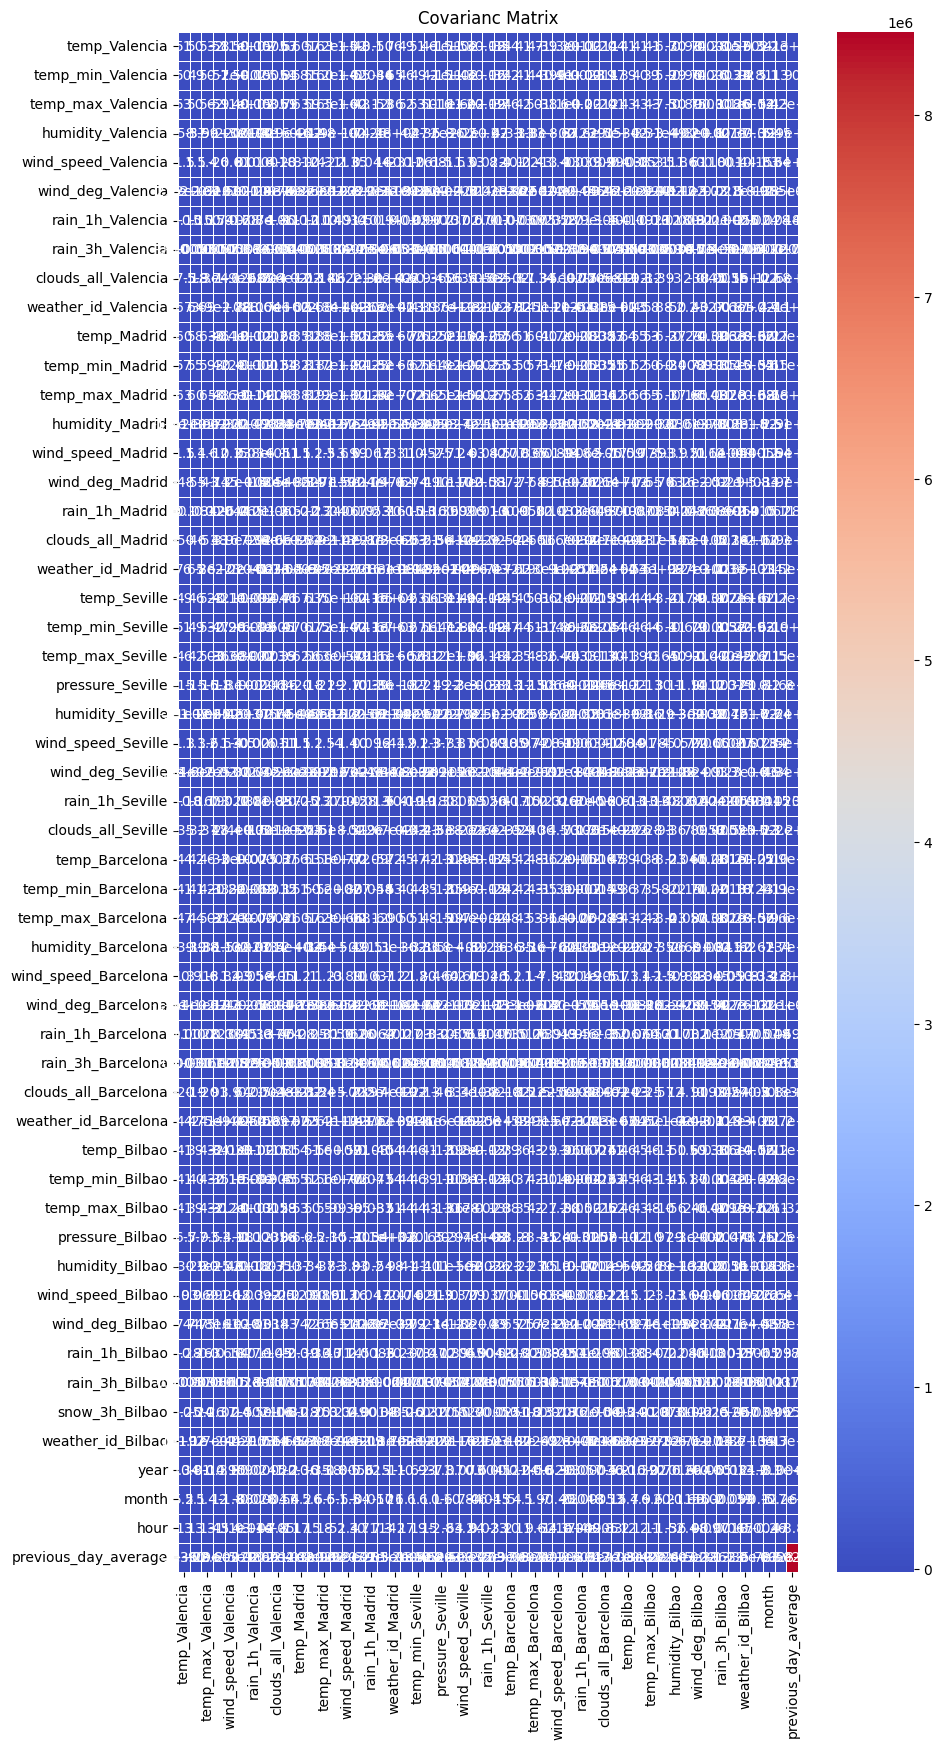

In [42]:
#Plot the relationship between numerical data and total load consumption 
clean_df = load_predictor.get_df()
clean_df
cl_df=clean_df.drop(columns=(['dt_iso','Unnamed: 0']))
cl_df=cl_df.select_dtypes(include=['float64','int64'])
cov_matrix=cl_df.cov()

plt.figure(figsize=(10,20))
sns.heatmap(cov_matrix,annot=True,cmap='coolwarm',linewidths=0.5)
plt.title("Covarianc Matrix")
plt.show()